In [1]:
import os, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score, confusion_matrix, classification_report, precision_score, recall_score, brier_score_loss
from scipy.stats import spearmanr, kendalltau, pearsonr, shapiro
from sklearn.calibration import calibration_curve

from matplotlib.ticker import MaxNLocator
import pingouin as pg
import random
%matplotlib inline

In [2]:
def patient_distance(df, ax, title, gt_dict, fontsize=20, xlabel=True, ylabel=True, markersize=5, alpha=0.5):
#     ###########################################################
#     if df['label'].isnull().values.any():
#         new_pred = np.array([j for j in df['prediction']])
#         pred_class = new_pred.argmax(1)
#         df['pred_class'] = pred_class
#         df['label'].fillna(df['pred_class'], inplace=True)

#     if df['label'].isnull().values.any():
#         df['label'].fillna(2, inplace=True)
#     ###########################################################
    df['gt_label_str'] = [gt_dict[int(i)] for i in df['label']]
    n_class = df['label'].max() + 1
    df_2img = df[df['img_per_patient'] > 1]
    for idx, label in enumerate(gt_dict.values()):
        ax.plot(df_2img[df_2img['label'] == idx]['patient_mean'], 
                df_2img[df_2img['label'] == idx]['patient_diff'], "o", label=label, markersize=markersize, alpha=alpha)
    ax.axhline(df_2img['patient_diff'].mean(), linestyle="--")
    ax.axhline(np.percentile(df_2img['patient_diff'], 2.5), linestyle="--")
    ax.axhline(np.percentile(df_2img['patient_diff'], 97.5), linestyle="--")

    if xlabel:
        ax.set_xlabel('Mean', fontsize=fontsize)
    if ylabel:
        ax.set_ylabel('Difference', fontsize=fontsize)
        
    # Add legends
    markerscale = 4.
#     if xlabel and ylabel:
#         ax.legend(fontsize=fontsize+2, ncol=1, bbox_to_anchor=(1.1, -0.3), markerscale=markerscale)
    if "FOC_MC" in title:
        ax.legend(fontsize=fontsize+2, ncol=3, bbox_to_anchor=(2, -0.3), markerscale=markerscale)
    
    eps = 0.02
    ax.set_ylim(-np.round(df['score'].max()) - eps, min(n_class, np.round(df['score'].max())) + eps)
    ax.set_title(title, fontsize=fontsize+2)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-3)

def print_metric(arr, name):
    print(f"{name}: {np.array(arr).mean()} +/- {(np.percentile(arr, 97.5) - np.percentile(arr, 2.5)) / 2} , CI: {np.percentile(arr, 2.5)}, {np.percentile(arr, 97.5)}")
        
def print_repeatability_metrics(df): # need to understand not_normal portion
    # Repeatability
    df_2img = df[df['img_per_patient'] > 1]

#     max_class = df.label.max()
    if df['label'].isnull().values.any():
        max_class = 2
    else:
        max_class = df.label.max()
    
    ids = df_2img.image.tolist()
    n = len(df_2img)
    print(f'Size of df_2img i.e. cases that have >1 image, before calculating repeatability metrics: {n}')
    
#     # With Shapiro-Wilks test for normality
#     b = 200 # 500, 200 attempted so far
#     print(f'Number of samples bootstrapped, before calculating repeatability metrics: {b}')
#     not_normal = True
#     while not_normal:
#         diff = []
#         loa = []
#         dis = []
#         for i in range(b):
#             temp_df = df_2img.sample(n, replace=True)
#             diff.append(abs(temp_df['patient_diff']).mean())
#             loa.append((np.percentile(temp_df['patient_diff'], 97.5) - np.percentile(temp_df['patient_diff'], 2.5)) / (2 * max_class))
#             dis.append(len(temp_df[temp_df['disagreement'] > 1]) / len(temp_df))
#         p_values = []
#         for bootstrap in [diff, loa, dis]:
#             stat, p = shapiro(bootstrap)
#             p_values.append(p)

#         not_normal = np.any(np.array(p_values) < 0.05)
    
    # Without Shapiro-Wilks test for normality, b = 500
    b = 500
    print(f'Number of samples bootstrapped, before calculating repeatability metrics: {b}')
    diff = []
    loa = []
    dis = []
    for i in range(b):
        temp_df = df_2img.sample(n, replace=True)
        diff.append(abs(temp_df['patient_diff']).mean())
        loa.append((np.percentile(temp_df['patient_diff'], 97.5) - np.percentile(temp_df['patient_diff'], 2.5)) / (2 * max_class))
        dis.append(len(temp_df[temp_df['disagreement'] > 1]) / len(temp_df))
    
    ################################################################################################################################
    print(f"\nactual Avg. abs. diff.: {abs(df_2img['patient_diff']).mean()}")
    print_metric(diff, 'Avg. abs. diff., bootstrap mean/CI')
    
    print(f"\nactual LoA: {(np.percentile(df_2img['patient_diff'], 97.5) - np.percentile(df_2img['patient_diff'], 2.5)) / (2 * max_class)}")
    print_metric(loa, 'LoA')
    
    print(f"\nactual disagreement rate: {len(df_2img[df_2img['disagreement'] > 1]) / len(df_2img)}")
    print_metric(dis, 'disagreement rate')
    print('\n')

def get_auroc(df, pred, gt_colname):
    n_class = df[gt_colname].max()
    roc = []

    if n_class == 1:
        for i in range(2):
            fpr, tpr, thr = roc_curve(df[gt_colname].tolist(), df['auc' + str(i)])
            roc.append(auc(fpr, tpr))
        
    else:
        for i in range(2):
            pos = i if i == 0 else n_class
            fpr, tpr, thr = roc_curve(df[gt_colname].tolist(), df['auc' + str(i)], pos_label=pos)
            roc.append(auc(fpr, tpr))
    return roc
    
def print_classification_metrics(df, pred, gt_colname, image_colname, pt_colname, view_colname=None, need_view=False):
    # Classification
    ids = df[image_colname].tolist()
    n = len(df)
    print(f'Size of df, before calculating classification metrics, inside print_classification_metrics function: {n}')
    
#     # With Shapiro-Wilks test for normality
#     b = 500
#     print(f'Number of samples bootstrapped, before calculating classification metrics: {b}')
#     not_normal = True
#     while not_normal:
#         acc = []
#         k_unw = []
#         k_lin = []
#         k_qw = []
#         auc_normal = []
#         auc_severe = []
#         for i in range(b):
#             temp_df = df.sample(n, replace=True)
#             k_unw.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred))
#             k_lin.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred, weights='linear'))
#             k_qw.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred, weights='quadratic'))
#             acc.append((temp_df[gt_colname] == temp_df.bin_pred).sum() / len(temp_df))
#             roc = get_auroc(temp_df, pred, gt_colname)
#             auc_normal.append(roc[0])
#             auc_severe.append(roc[1])
#         p_values = []
#         for bootstrap in [acc, k_qw, auc_normal]:
#             stat, p = shapiro(bootstrap)
#             p_values.append(p)

#         not_normal = np.any(np.array(p_values) < 0.05)
    
    # Without Shapiro-Wilks test for normality, b= 1000
    b = 1000
    print(f'Number of samples bootstrapped, before calculating classification metrics: {b}')
    acc = []
    k_unw = []
    k_lin = []
    k_qw = []
    auc_normal = []
    auc_severe = []
    for i in range(b):
        temp_df = df.sample(n, replace=True)
        k_unw.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred))
        k_lin.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred, weights='linear'))
        k_qw.append(cohen_kappa_score(temp_df[gt_colname], temp_df.bin_pred, weights='quadratic'))
        acc.append((temp_df[gt_colname] == temp_df.bin_pred).sum() / len(temp_df))
        roc = get_auroc(temp_df, pred, gt_colname)
        auc_normal.append(roc[0])
        auc_severe.append(roc[1])
    
    #####################################################################
    # Only select those cases that have 2 raters for icc calculation (to verify that the nan I am getting is not some other error)
    if need_view:
        new_df = df.copy()

        for item in new_df[pt_colname].values:
            if len(new_df.loc[df[pt_colname]==item]) <= 1 or len(new_df.loc[df[pt_colname]==item]) > 2:
                new_df = new_df.drop(new_df.loc[df[pt_colname]==item].index.values)        

        icc = pg.intraclass_corr(data=new_df, targets=pt_colname, raters=view_colname, ratings='score', nan_policy='omit')
    ######################################################################
    print(f"\nactual kappa_unw: {cohen_kappa_score(df[gt_colname], df.bin_pred)}")
    print_metric(k_unw, 'kappa_unw, bootstrap mean/CI')
    
    print(f"\nactual kappa_lin: {cohen_kappa_score(df[gt_colname], df.bin_pred, weights='linear')}")
    print_metric(k_lin, 'kappa_lin, bootstrap mean/CI')
    
    print(f"\nactual kappa_qw: {cohen_kappa_score(df[gt_colname], df.bin_pred, weights='quadratic')}")
    print_metric(k_qw, 'kappa_qw, bootstrap mean/CI')
    
    print(f"\nactual accuracy: {(df[gt_colname] == df.bin_pred).sum() / len(df)}")
    print_metric(acc, 'accuracy, bootstrap mean/CI')
    
    roc = get_auroc(df, pred, gt_colname)
    print(f"\nactual auc0: {roc[0]}")
    print_metric(auc_normal, 'AUROC Normal, bootstrap mean/CI')
    print(f"actual auc1: {roc[1]}")
    print_metric(auc_severe, 'AUROC Severe, bootstrap mean/CI')
    if need_view:
        print(f'\nSize of new_df, after selecting cases with only 2 raters before calculating icc: {len(new_df)}')
        print(f"icc: {np.array(icc.loc[icc.Type == 'ICC2k', 'ICC'].item()).mean()}, CI: {icc.loc[icc.Type == 'ICC2k', 'CI95%'].item()}")

    
def modify_pred_for_roc(df, pred, model_type):
    if model_type == 'binary':
        df['auc0'] = pred.flatten()
        df['auc1'] = pred.flatten()
    elif model_type == 'multi_class':
        df['auc0'] = pred[:, 0]
        df['auc1'] = pred[:, -1]
    elif model_type == 'ordinal':
        df['auc0'] = 1 - pred[:, 0]
        df['auc1'] = pred[:, 1]        
    elif model_type == 'regression':
        max_value = pred.max()
        df['auc0'] = max_value - pred[:, 0]
        df['auc1'] = pred[:, 0]        
        
    
def combine_by_patient(df, gt_colname='label', image_colname='image', pt_colname='patient'):
    diff = lambda x: x[0] - x[1]
    def get_abs_max(l):
        if len(l) < 1:
            return 0
        else:
            return max(l, key=abs)
        
    df = df.groupby(pt_colname).agg(
    score=pd.NamedAgg(column='score', aggfunc='mean'),
    image=pd.NamedAgg(column=image_colname, aggfunc='max'),
    label=pd.NamedAgg(column=gt_colname, aggfunc='mean'),
    disagreement=pd.NamedAgg(column='bin_pred', aggfunc=lambda x: len(np.unique(x))),
    patient_diff=pd.NamedAgg(column='score', aggfunc=lambda x: get_abs_max(list(map(diff, list(itertools.combinations(x, 2)))))),
    patient_mean=pd.NamedAgg(column='score', aggfunc='mean'),
    img_per_patient=pd.NamedAgg(column=gt_colname, aggfunc=lambda x: len(x)),
    prediction=pd.NamedAgg(column='prediction', aggfunc=lambda x: list(np.array(x).mean(0))))
    print(f'Size of df after grouping by patients i.e. patients with multiple images: {len(df)}')
    df = df.explode('patient_diff')
    df['patient_diff'] = df['patient_diff'].astype('float')
    print(f'Size of df after grouping and then exploding by patient_diff: {len(df)}')
    
    ###########################################################
#     if df['label'].isnull().values.any():
#         new_pred = np.array([j for j in df['prediction']])
#         pred_class = new_pred.argmax(1)
#         df['pred_class'] = pred_class
#         df['label'].fillna(df['pred_class'], inplace=True)
        
#     if df['label'].isnull().values.any():
#         df['label'].fillna(2, inplace=True)
    ###########################################################
    
    return df
 
def get_df_per_patient(df, pred, bin_pred, score, do_clfmet_print=True, do_repmet_print=True, gt_colname='label', image_colname='image', pt_colname='patient', view_colname='view', need_view=False, model_type=None):
    df['prediction'] = list(pred)
    df['score'] = score
    df['bin_pred'] = bin_pred
    if need_view:
        if view_colname not in df.columns:
            df['view'] = None
            for item in df[pt_colname].values:
                new_df = df.loc[df[pt_colname]==item].copy()
                for a in range(len(new_df.index.values)):
                    new_df.loc[new_df.index.values[a],'view'] = a+1 #'A'+str(a+1)
                for b in new_df.index.values:
                    df.loc[b, 'view'] = new_df['view'].loc[b]
    
    if do_clfmet_print:
        print(f'\nClassification Metrics:\n')               
        print(f'Size of df before print_classification_metrics function: {len(df)}')               
        modify_pred_for_roc(df, pred, model_type)
        print_classification_metrics(df, pred, gt_colname, image_colname, pt_colname, view_colname, need_view)
    print(f'\nRepeatability Metrics:\n')               
    df = combine_by_patient(df, gt_colname, image_colname, pt_colname)
    print(f'Size of df between combine_by_patient AND print_repeatability_metrics functions {len(df)}')
    if do_repmet_print:
        print_repeatability_metrics(df)
    return df

def get_mc_pred(df, n_it=50):
    return get_mc_arr(df, n_it).mean(0)

def get_mc_arr(df, n_it=50):
    mc_pred = []
    for i in range(n_it):
        col_name = "mc_epistemic_" + str(i)
        mc_pred.append([eval(j) for j in df[col_name]])
    return np.array(mc_pred)

def get_classification_score(arr):
    return np.sum(arr * np.repeat(np.arange(1, arr.shape[-1] + 1)[None, ], arr.shape[0], axis=0), -1) - 1

def proba_to_label(probas):
    predict_levels = probas > 0.5
    predicted_labels = np.sum(predict_levels, axis=1)
    return predicted_labels

def binarize(pred, n_class=3):
    gt_max = pred.max()
    gt_min = min(pred.min(), 0)
    c_pred = []
    thr = [gt_min]
    for c in range(n_class - 1):
        new_thr = (c + 1) * ((n_class - 1) / n_class)
        thr.append(new_thr)

    thr.append(gt_max)
    for s in pred:
        for t in range(n_class):
            if (s[0] <= thr[t + 1]) and (s[0] >= thr[t]):
                c_pred.append(t)
                break

    return np.array(c_pred)

In [4]:
def patient_distance(df, ax, title, gt_dict, fontsize=20, xlabel=True, ylabel=True, markersize=5, alpha=0.5):
    df['gt_label_str'] = [gt_dict[int(i)] for i in df['label']]
    n_class = df['label'].max() + 1
    df_2img = df[df['img_per_patient'] > 1]
    for idx, label in enumerate(gt_dict.values()):
        ax.plot(df_2img[df_2img['label'] == idx]['patient_mean'], 
                df_2img[df_2img['label'] == idx]['patient_diff'], "o", label=label, markersize=markersize, alpha=alpha)
    ax.axhline(df_2img['patient_diff'].mean(), linestyle="--")
    ax.axhline(np.percentile(df_2img['patient_diff'], 2.5), linestyle="--")
    ax.axhline(np.percentile(df_2img['patient_diff'], 97.5), linestyle="--")

    if xlabel:
        ax.set_xlabel('Mean', fontsize=fontsize)
    if ylabel:
        ax.set_ylabel('Difference', fontsize=fontsize)
        
    eps = 0.02
    ax.set_ylim(-np.round(df['score'].max()) - eps, min(n_class, np.round(df['score'].max())) + eps)
    ax.set_title(title, fontsize=fontsize-5)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-3)

def generate_results(ax, df_mc, gt_dict, figname, fontsize=20, xlabel=True, ylabel=True, gt_colname='label', image_colname='image', pt_colname='patient', view_colname='view', print_clf=True, print_rep=True, need_view=True, num_plots=6, markersize=5, alpha=0.5):
    dashes = '-' * 100

    # All_MC
    #print(dashes)
    #print(figname)
    pred_mc = get_mc_pred(df_mc, n_it=50)
    # pred_mc = np.array([eval(j) for j in df_mc['pred']])
    df_mc_c = get_df_per_patient(df_mc, pred_mc, pred_mc.argmax(1), get_classification_score(pred_mc), do_clfmet_print=print_clf, do_repmet_print=print_rep, gt_colname=gt_colname, image_colname=image_colname, pt_colname=pt_colname, need_view=need_view, model_type='multi_class')
    patient_distance(df_mc_c, ax, figname, gt_dict, fontsize=fontsize, xlabel=xlabel, ylabel=ylabel, markersize=markersize, alpha=alpha)

    #print(dashes)
    #print('\n')
    return df_mc_c

def histogram_plot_score(df, ax, title, gt_dict, gt_colname='label', patient_level=False, fontsize=20, xlabel=True, ylabel=True, bins=50, markersize=5):
    df['gt_label_str'] = [gt_dict[int(i)] for i in df[gt_colname]]
    n_class = df[gt_colname].max() + 1
    
    if patient_level:
        df_2img = df[df['img_per_patient'] > 1]
        for idx, label in enumerate(gt_dict.values()):
            ax.hist(df_2img[df_2img[gt_colname] == idx]['patient_mean'], bins=bins, alpha=0.5, label=label)
    else:
        for idx, label in enumerate(gt_dict.values()):
            ax.hist(df[df[gt_colname] == idx]['score'], bins=bins, alpha=0.5, label=label)
        
    if xlabel:
        if patient_level:
            ax.set_xlabel('Mean Score', fontsize=fontsize)
        else:
            ax.set_xlabel('Score', fontsize=fontsize)
    if ylabel:
        ax.set_ylabel('Frequency', fontsize=fontsize)
   
    ax.set_title(title, fontsize=fontsize-5)
    ax.grid(visible=True)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize-3)

# Model trained with experiment 138 configuration


Classification Metrics:

Size of df before print_classification_metrics function: 924
Size of df, before calculating classification metrics, inside print_classification_metrics function: 924
Number of samples bootstrapped, before calculating classification metrics: 1000

actual kappa_unw: 0.45599448584844704
kappa_unw, bootstrap mean/CI: 0.45652124190332405 +/- 0.047118548332336474 , CI: 0.40847354834929284, 0.5027106450139658

actual kappa_lin: 0.5201172335575444
kappa_lin, bootstrap mean/CI: 0.5203105007634728 +/- 0.04577506834261308 , CI: 0.4743659178439359, 0.565916054529162

actual kappa_qw: 0.5899547235320337
kappa_qw, bootstrap mean/CI: 0.5897670122352374 +/- 0.04883732230245824 , CI: 0.5397212088640367, 0.6373958534689532

actual accuracy: 0.645021645021645
accuracy, bootstrap mean/CI: 0.6455367965367965 +/- 0.030857683982684014 , CI: 0.6146915584415584, 0.6764069264069265

actual auc0: 0.8737421755476513
AUROC Normal, bootstrap mean/CI: 0.8733947570970827 +/- 0.02232773266754

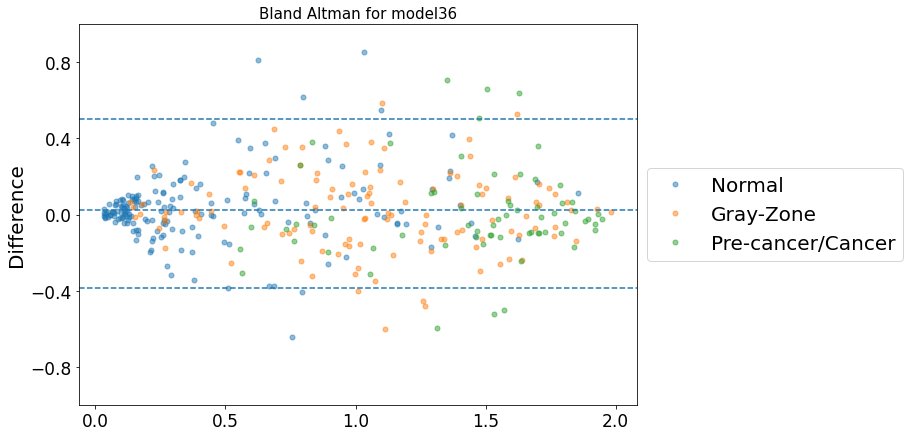

In [13]:
######### Predictions based on snapshot averaging

base_dir_val = './results/'
item = 'experiment2'
csv_file_val = 'predictions_validation.csv'
df_val = pd.read_csv(os.path.join(os.path.join(base_dir_val, item), csv_file_val))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cervix_gt_dict = {0: 'Normal', 1: 'Gray-Zone', 2: 'Pre-cancer/Cancer'}

# Model 36
df = df_val
df_c_36 = generate_results(ax, df, cervix_gt_dict, 'Bland Altman for model36', xlabel=False, ylabel=True, gt_colname='CC_ST', image_colname='MASKED_IMG_ID', pt_colname='ID', print_clf=True, print_rep=True, need_view=False, alpha=0.5)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1,1)
plt.show()



Classification Metrics:

Size of df before print_classification_metrics function: 924
Size of df, before calculating classification metrics, inside print_classification_metrics function: 924
Number of samples bootstrapped, before calculating classification metrics: 1000

actual kappa_unw: 0.43689640585903056
kappa_unw, bootstrap mean/CI: 0.43678461234371796 +/- 0.04599534251318424 , CI: 0.3917873529517587, 0.4837780379781272

actual kappa_lin: 0.5025364933118721
kappa_lin, bootstrap mean/CI: 0.5024769990572651 +/- 0.04633425159417004 , CI: 0.4560918537909575, 0.5487603569792976

actual kappa_qw: 0.5725427824251785
kappa_qw, bootstrap mean/CI: 0.5725381511579085 +/- 0.05069318870420847 , CI: 0.5208206124894919, 0.6222069898979088

actual accuracy: 0.6320346320346321
accuracy, bootstrap mean/CI: 0.6321255411255412 +/- 0.03085768398268396 , CI: 0.6017045454545455, 0.6634199134199135

actual auc0: 0.8742730558920478
AUROC Normal, bootstrap mean/CI: 0.8744578454244386 +/- 0.022954081561667

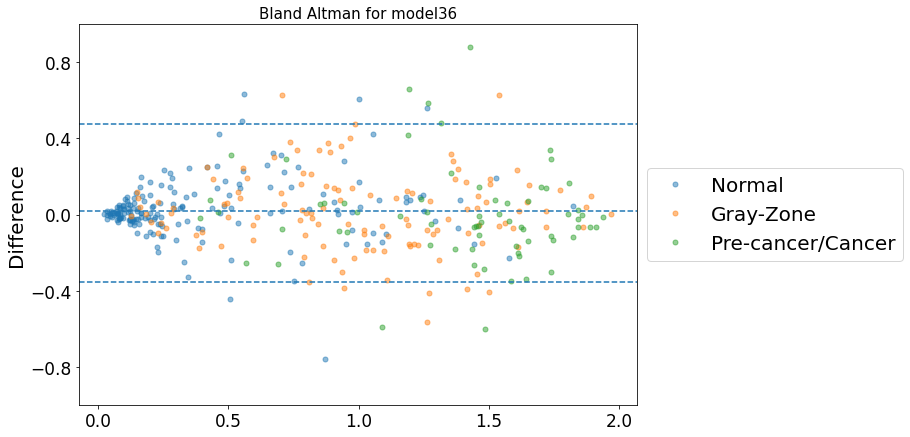

In [16]:
######### Predictions based on best model

csv_file_val = 'predictions_validation_orig.csv'
df_val = pd.read_csv(os.path.join(os.path.join(base_dir_val, item), csv_file_val))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cervix_gt_dict = {0: 'Normal', 1: 'Gray-Zone', 2: 'Pre-cancer/Cancer'}

# Model 36
df = df_val
df_c_36 = generate_results(ax, df, cervix_gt_dict, 'Bland Altman for model36', xlabel=False, ylabel=True, gt_colname='CC_ST', image_colname='MASKED_IMG_ID', pt_colname='ID', print_clf=True, print_rep=True, need_view=False, alpha=0.5)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1,1)
plt.show()

# Model trained with experiment 138 configuration with RAdam optimizer


Classification Metrics:

Size of df before print_classification_metrics function: 924
Size of df, before calculating classification metrics, inside print_classification_metrics function: 924
Number of samples bootstrapped, before calculating classification metrics: 1000

actual kappa_unw: 0.4524287117564768
kappa_unw, bootstrap mean/CI: 0.45295257984003773 +/- 0.04592913677468341 , CI: 0.4062023819949207, 0.4980606555442875

actual kappa_lin: 0.5230738837304425
kappa_lin, bootstrap mean/CI: 0.5233802827000883 +/- 0.04371933413123477 , CI: 0.4786239245523442, 0.5660625928148137

actual kappa_qw: 0.5985367575406477
kappa_qw, bootstrap mean/CI: 0.598556098430929 +/- 0.04775883380536261 , CI: 0.5500160971686344, 0.6455337647793596

actual accuracy: 0.6428571428571429
accuracy, bootstrap mean/CI: 0.6433300865800866 +/- 0.03030303030303033 , CI: 0.6125541125541125, 0.6731601731601732

actual auc0: 0.8767778458806098
AUROC Normal, bootstrap mean/CI: 0.8767257388999932 +/- 0.02162384170947023

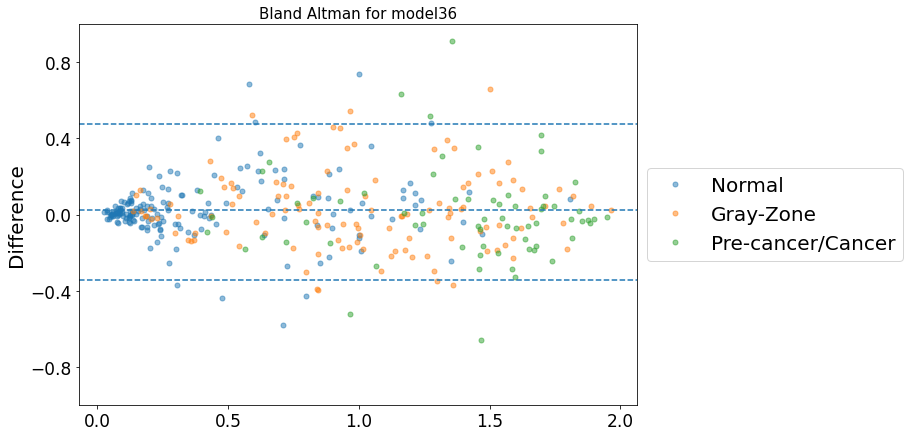

In [17]:
######### Predictions based on snapshot averaging

base_dir_val = './results/'
item = 'experiment3'
csv_file_val = 'predictions_validation.csv'
df_val = pd.read_csv(os.path.join(os.path.join(base_dir_val, item), csv_file_val))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cervix_gt_dict = {0: 'Normal', 1: 'Gray-Zone', 2: 'Pre-cancer/Cancer'}

# Model 36
df = df_val
df_c_36 = generate_results(ax, df, cervix_gt_dict, 'Bland Altman for model36', xlabel=False, ylabel=True, gt_colname='CC_ST', image_colname='MASKED_IMG_ID', pt_colname='ID', print_clf=True, print_rep=True, need_view=False, alpha=0.5)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1,1)
plt.show()


Classification Metrics:

Size of df before print_classification_metrics function: 924
Size of df, before calculating classification metrics, inside print_classification_metrics function: 924
Number of samples bootstrapped, before calculating classification metrics: 1000

actual kappa_unw: 0.43689640585903056
kappa_unw, bootstrap mean/CI: 0.43723654776161297 +/- 0.04701154925233239 , CI: 0.3910816781595885, 0.4851047766642533

actual kappa_lin: 0.5025364933118721
kappa_lin, bootstrap mean/CI: 0.5029029384026481 +/- 0.04455996779175739 , CI: 0.45918651225090984, 0.5483064478344246

actual kappa_qw: 0.5725427824251785
kappa_qw, bootstrap mean/CI: 0.5730314806538886 +/- 0.04826657739657059 , CI: 0.5245226839949114, 0.6210558387880526

actual accuracy: 0.6320346320346321
accuracy, bootstrap mean/CI: 0.6324534632034631 +/- 0.03030303030303033 , CI: 0.6028138528138528, 0.6634199134199135

actual auc0: 0.8742730558920478
AUROC Normal, bootstrap mean/CI: 0.8743972781034952 +/- 0.02226133131444

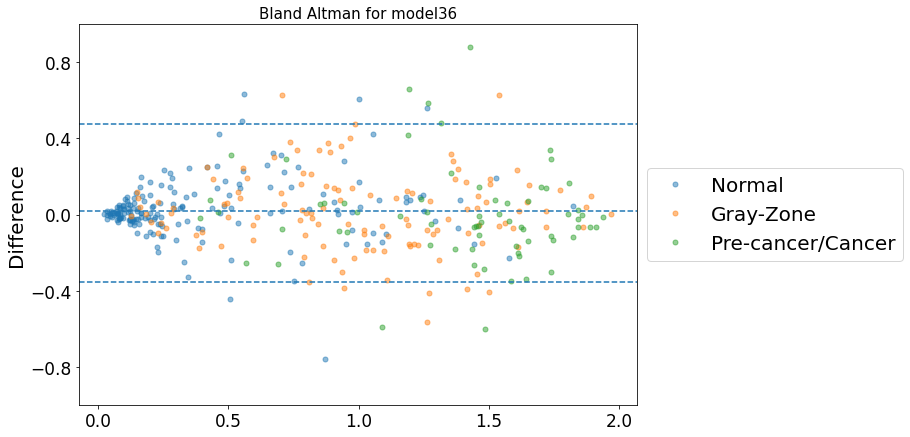

In [18]:
######### Predictions based on best model

base_dir_val = './results/'
item = 'experiment3'
csv_file_val = 'predictions_validation_orig.csv'
df_val = pd.read_csv(os.path.join(os.path.join(base_dir_val, item), csv_file_val))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cervix_gt_dict = {0: 'Normal', 1: 'Gray-Zone', 2: 'Pre-cancer/Cancer'}

# Model 36
df = df_val
df_c_36 = generate_results(ax, df, cervix_gt_dict, 'Bland Altman for model36', xlabel=False, ylabel=True, gt_colname='CC_ST', image_colname='MASKED_IMG_ID', pt_colname='ID', print_clf=True, print_rep=True, need_view=False, alpha=0.5)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-1,1)
plt.show()